## Load data

We first load the spiking data as a tensor `mask_spikes_d` with {0, 1} values and we define a 1d tensor `t` with the time points

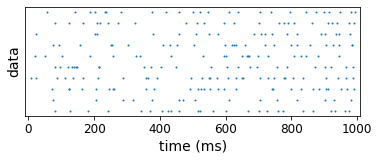

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from mmdglm.utils import plot_spiketrain
from examples_utils import fig_layout, plot_fit, psth_and_autocor, set_style

set_style()

mask_spikes_d = np.load('./monkey_pmv.npy')
mask_spikes_d = torch.from_numpy(mask_spikes_d).float()

dt = 1
t = torch.arange(0, len(mask_spikes_d), 1) * dt

ax = plot_spiketrain(t, mask_spikes_d, label='data')

We compute quantities that we will use to assess goodness-of-fit of the models we will fit

In [2]:
from mmdglm.convkernels.values import KernelBasisValues
from mmdglm.metrics import bernoulli_log_likelihood_pp

n_spk = torch.sum(mask_spikes_d) # total number of spikes
ll_pp = bernoulli_log_likelihood_pp(mask_spikes_d) # bernoulli likelihood of poisson process with the same rate

kernel_smooth = KernelBasisValues.gaussian(dt, tau=20) # gaussian kernel for smoothing spike trains
last_lag = 200 # last lag used in autocorrelation
t_autocor = torch.arange(0, last_lag, 1) # autocorrelation time points
    
psth_d, autocor_d = psth_and_autocor(t, mask_spikes_d, kernel_smooth=kernel_smooth, 
                                     smooth_autocor=True, last_lag=last_lag) # compute PSTH and autocorrelation of samples

## Fit ml-glm

We first fit a GLM by maximum likelihood. 

We load the basis values for the history filter and define a filter instance.

In [3]:
basis = np.load('basis.npy')
hist = KernelBasisValues(dt=dt, basis_values=basis)

We define a GLM instance and extract its parameters maximizing the likelihood using PyTorch.

In [4]:
from torch.optim import Adam
from mmdglm.glm.torch import TorchGLM

mlglm = TorchGLM(u0=-5, eta=hist)
optim = Adam(mlglm.parameters(), lr=1e-1)
loss, _ = mlglm.train(t, mask_spikes_d, num_epochs=200, optim=optim, verbose=True)

 epoch 199 of 200 || loss 1112.0385

We compute the log-likelihood of the ml-glm, generate samples and compute the psth and autocorrelation of the samples.

In [5]:
ll_ml = (-loss[-1] - ll_pp) / np.log(2) / n_spk # log-likelihood per spike relative to a poisson process with the same rate 

t_long = torch.arange(0, 3000, dt)
_, _, mask_spikes_ml = mlglm.sample(t_long, shape=(500,)) # generate 500 samples from ml-glm

psth_ml, autocor_ml = psth_and_autocor(t_long, mask_spikes_ml, kernel_smooth=kernel_smooth, last_lag=last_lag)

The ml-glm produces free-running samples with diverging firing rate due to the history filter's self excitation. The free-running samples also fail to capture the autocorrelation of the data samples.

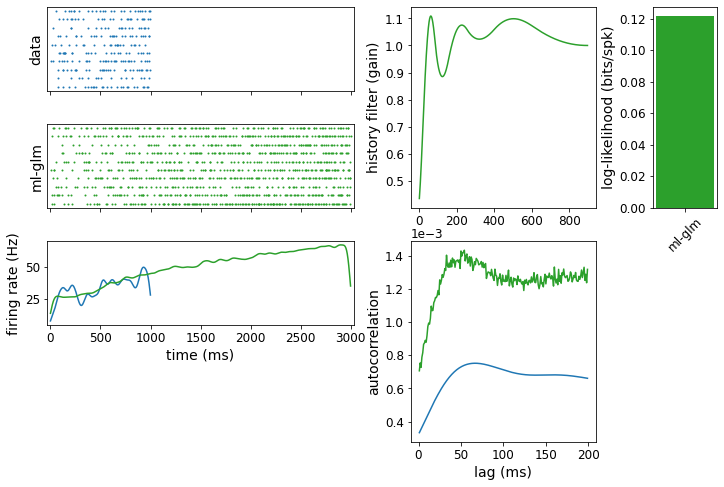

In [6]:
axs = fig_layout()
plot_fit(axs, label='data', mask_spikes=mask_spikes_d, psth=psth_d, autocor=autocor_d)
plot_fit(axs, label='ml-glm', mask_spikes=mask_spikes_ml[:, :10], psth=psth_ml, history_filter=mlglm.eta, autocor=autocor_ml, ll=ll_ml)

## Fit MMD-GLM

To improve the free-running behavior of the GLM we propose to optimize a kernel-induced statistic called Maximum Mean Discrepancy (MMD). Given a kernel $k$ or its associated feature map $\phi: X \rightarrow \mathscr{H}$, with $k(X, X')=\langle \phi(X), \phi(X') \rangle_{\mathscr{H}}$ and $\mathscr{H}$ the reproducing kernel Hilbert space, MMD measures the distance in $\mathscr{H}$ between the embeddings of two probability distributions $\hat{p}$ and $p$  

\begin{equation*}
d_\text{MMD}(\hat{p}, p)^2 = \left| \left| E_{X \sim \hat{p}}[\phi(X)] - E_{X' \sim p}[\phi(X')] \right| \right|_\mathscr{H}^2
\end{equation*}

In this example we minimize the objective function $\text{NLL} + \alpha \text{MMD}^2$, with $\text{NLL}$ the negative log-likelihood and $\alpha$ a hyperparameter that controls the relative weight of $\text{MMD}$. We use a model-based feature map, that is a feature map extracted from the GLM we are trying to fit. The feature map
\begin{equation*}
\phi(x; \theta) = \sum_{t=1}^\tau H_x(t; h) H_x(t + \tau; h) \hspace{1cm} H_x(t; h)=\sum_{\tau} h_\tau x_{t - \tau}
\end{equation*}
is the autocorrelation of $H_x$, the convolution of the history filter $h$ with the spike train $x$.

To minimize the induced MMD, we first define the function that computes this feature map from the conditional intensity $\lambda$.

In [7]:
import torch.nn.functional as F

def phi_autocor_history(t, lam, model, last_lag=500):
    """
    Returns the autocorrelation of the history term.
    Functions to compute model-based feature maps should be of the form phi(t, lam, model, **kwargs)
    """
    T = len(t)
    history = torch.log(lam) - model.b
    autocov = F.conv1d(history.T[None, :, :], history.T[:, None, :], padding=last_lag, groups=history.shape[1]) / T
    autocov = autocov[0, :, last_lag + 1:].T # get only positive lags
    return autocov

Then we use the `ModelBasedMMDGLM` class to optimize

In [8]:
from mmdglm.glm.modelbasedmmd import ModelBasedMMDGLM

alpha_mmd = 1.5e3 # MMD relative weight against NLL in the cost function
n_batch_fr = 50 # Number of free-running samples drawn at each iteration to compute MMD^2 and its gradient 
num_epochs = 300

mmdglm = ModelBasedMMDGLM(u0=mlglm.u0, eta=mlglm.eta.copy()) # We initialize the optimization the MLE values
optim = Adam(mmdglm.parameters(), lr=1e-2)

loss_mmd, metrics = mmdglm.train(t, mask_spikes_d, phi=phi_autocor_history, alpha_mmd=alpha_mmd, 
                                 n_batch_fr=n_batch_fr, num_epochs=num_epochs, optim=optim, verbose=True)

 epoch 299 of 300 || loss 1122.9917

MMD$^2$ decreases during optimization.

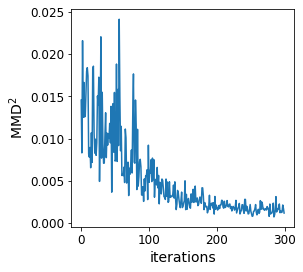

In [9]:
plt.plot(metrics['mmd'])
plt.xlabel('iterations')
plt.ylabel(r'MMD$^2$');

We compute the log-likelihood of the mmd-glm, generate samples and compute the psth and autocorrelation of the samples.

In [10]:
ll_mmd = (-metrics['nll'][-1] - ll_pp) / np.log(2) / n_spk
_, _, mask_spikes_mmd = mmdglm.sample(t_long, shape=(500,))
psth_mmd, autocor_mmd = psth_and_autocor(t_long, mask_spikes_mmd, kernel_smooth=kernel_smooth, last_lag=last_lag)

The mmd-glm produces free-running samples with stable firing rate by preferentially reducing the history filter's late self excitation. The free-running samples better match the autocorrelation of the data samples. 

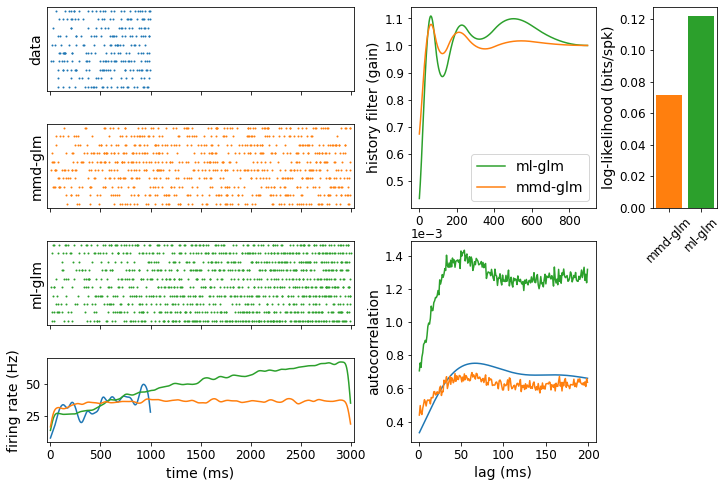

In [11]:
axs = fig_layout(mmd=True)
plot_fit(axs, label='data', mask_spikes=mask_spikes_d, psth=psth_d, autocor=autocor_d)
plot_fit(axs, label='ml-glm', mask_spikes=mask_spikes_ml[:, :10], psth=psth_ml, history_filter=mlglm.eta, autocor=autocor_ml, ll=ll_ml)
plot_fit(axs, label='mmd-glm', mask_spikes=mask_spikes_mmd[:, :10], psth=psth_mmd, history_filter=mmdglm.eta, autocor=autocor_mmd, ll=ll_mmd)
axs[2].legend(frameon=True);